In [1]:
!pip install pyodbc

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [92]:
import seaborn as sns
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from pandas import to_datetime
import pyodbc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [174]:
server = 'dbserver'
database = 'NEXUM_FABRIC'
username = 'amits'
password = 'amit12345'

# Connection string
connection_string = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={{{password}}};'
)

conn = None
cursor = None

try:
    # Establishing a connection to the SQL Server
    conn = pyodbc.connect(connection_string)

    # Instantiate a cursor
    cursor = conn.cursor()

    # Execute the second query to get id, idcase, idcodeplabel, idcodeworkstage, amount, dtcreate
    cursor.execute("""
    SELECT
        FORMAT(dtcreate, 'yyyy-MM') AS payment_month,
        SUM(amount) AS total_amount
    FROM
        aps_trans
    WHERE
        idcodeplabel = 'PAY'
        AND YEAR(dtcreate) BETWEEN 2014 AND 2023
    GROUP BY
        FORMAT(dtcreate, 'yyyy-MM')
    ORDER BY
        payment_month;
    """)
    rows = cursor.fetchall()
    # Fetch all rows from the result set of the second query
    df = pd.DataFrame([tuple(row) for row in rows], columns=[col[0] for col in cursor.description])

    print(df.head(5))

except pyodbc.Error as ex:
    print(f"Error: {ex}")
finally:
    # Close the cursor in a finally block if it is still open
    if cursor:
        cursor.close()





  payment_month total_amount
0       2014-11       492.02
1       2014-12   1104501.72
2       2015-01   3264438.51
3       2015-02   5774512.00
4       2015-03   6595677.07


In [157]:
df

,payment_month,total_amount
0,2014-11,492.02
1,2014-12,1104501.72
2,2015-01,3264438.51
3,2015-02,5774512.00
4,2015-03,6595677.07
...,...,...
104,2023-07,13691524.10
105,2023-08,13546074.69
106,2023-09,12012384.04
107,2023-10,12478845.53


In [158]:
df.tail(20)

,payment_month,total_amount
89,2022-04,14412899.74
90,2022-05,17165378.01
91,2022-06,13480790.38
92,2022-07,14809471.68
93,2022-08,15237806.96
94,2022-09,14304330.99
95,2022-10,15952576.21
96,2022-11,17691407.21
97,2022-12,16806230.52
98,2023-01,18428979.17


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   payment_month  109 non-null    object
 1   total_amount   109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [160]:
df.isna().sum()

payment_month    0
total_amount     0
dtype: int64

In [98]:
df['total_amount']=df['total_amount'].astype(float)
df['payment_month']=pd.to_datetime(df['payment_month'])

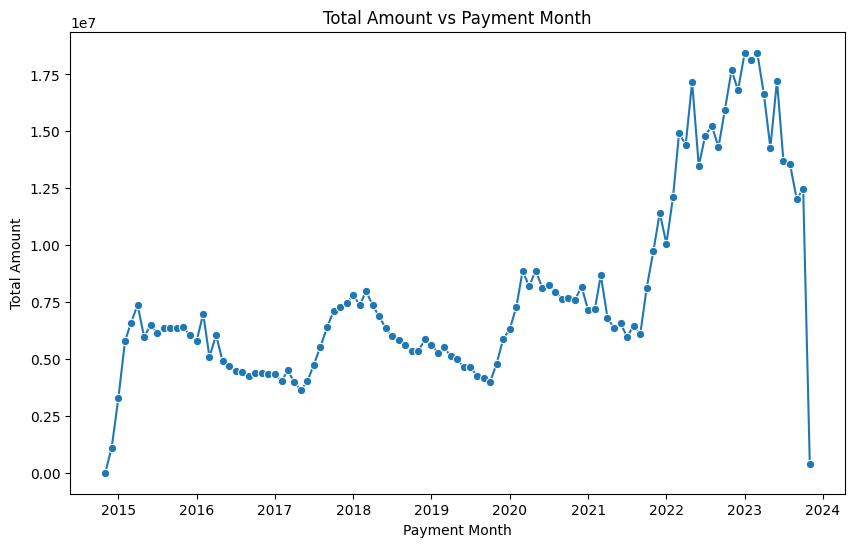

In [99]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='payment_month', y='total_amount', data=df, marker='o')
plt.title('Total Amount vs Payment Month')
plt.xlabel('Payment Month')
plt.ylabel('Total Amount')
plt.show()

Univariate Analysis

In [100]:
q1=np.quantile(df['total_amount'],0.25)
q3=np.quantile(df['total_amount'],0.75)
IQRamount=q3-q1

In [101]:
outlierupper=q3+3*IQRamount
outlierdown=q1-3*IQRamount
print(outlierupper,outlierdown)

17626203.2 -4265787.55


In [102]:
k=0
a=[]
for i in range(0,len(df['total_amount'])):
    if(df['total_amount'][i]<q1-3*IQRamount or df['total_amount'][i]>q3+3*IQRamount):
        print(df['total_amount'][i])
        k=k+1
        a.append(i)
print("the total outliers of total_amount",k)

17691407.21
18428979.17
18137035.6
18452896.74
the total outliers of total_amount 4


Outliers data of inv_amount

In [15]:
print(a)

[96, 98, 99, 100]


In [103]:
# Drop rows using iloc without creating a separate list
df.drop(df.index[a], inplace=True)


In [104]:
df.shape

(105, 2)

In [18]:
# Calculate IQR
IQRINV = q3 - q1

# Create a boolean mask for outliers
outliers_mask = (df['total_amount'] < q1 - 3 * IQRINV) | (df['total_amount'] > q3 + 3 * IQRINV)

# Print the data for outliers including all columns
outliers_data = df[outliers_mask]
print(outliers_data)

# Print the total number of outliers
print("The total outliers of total_amount:", outliers_data.shape[0])

Empty DataFrame
Columns: [payment_month, total_amount]
Index: []
The total outliers of total_amount: 0


analysis of pay_amount column

In [19]:
len(df)

105

In [20]:
df.shape

(105, 2)

<Figure size 1000x400 with 0 Axes>

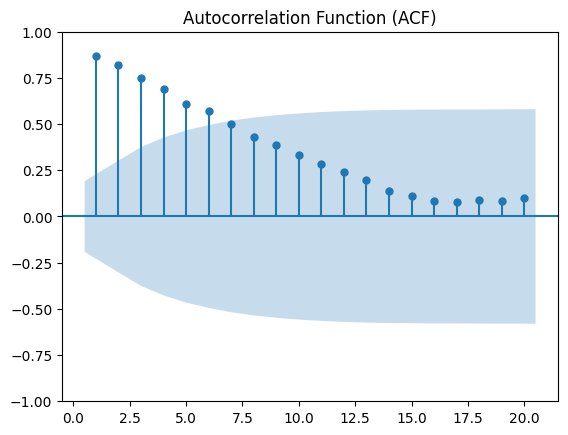

<Figure size 1000x400 with 0 Axes>

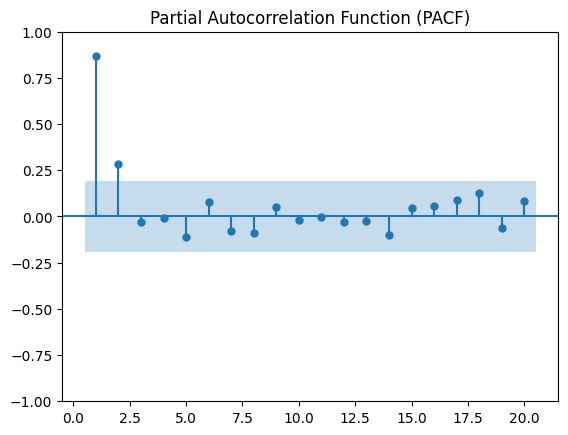

In [21]:
# Set 'payment_month' as the index
df.set_index('payment_month', inplace=True)

# Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(df['total_amount'], lags=20, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 4))
plot_pacf(df['total_amount'], lags=20, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [22]:
# Perform ADF test
result = adfuller(df['total_amount'])

# Extract and print ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:', {key: value for key, value in critical_values.items()})

# Interpret the results
if p_value <= 0.05:
    print('Reject the null hypothesis. The time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The time series may not be stationary.')

ADF Statistic: -2.586892118016566
p-value: 0.09573677600330915
Critical Values: {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}
Fail to reject the null hypothesis. The time series may not be stationary.


In [26]:
# Take the first difference
df['total_amount_diff'] = df['total_amount'].diff()

# Drop any missing values introduced by differencing
df.dropna(inplace=True)

# Perform ADF test on the differenced series
result_diff = adfuller(df['total_amount_diff'])

# Extract and print ADF test results for the differenced series
adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]
critical_values_diff = result_diff[4]

print(f'ADF Statistic (after differencing): {adf_statistic_diff}')
print(f'p-value (after differencing): {p_value_diff}')
print('Critical Values (after differencing):', {key: value for key, value in critical_values_diff.items()})

# Interpret the results after differencing
if p_value_diff <= 0.05:
    print('Reject the null hypothesis. The differenced time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The differenced time series may not be stationary.')

ADF Statistic (after differencing): -1.7239758732535042
p-value (after differencing): 0.4188036382976471
Critical Values (after differencing): {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
Fail to reject the null hypothesis. The differenced time series may not be stationary.


In [27]:
# Take the second difference
df['total_amount_diff2'] = df['total_amount_diff'].diff()

# Drop any missing values introduced by second differencing
df.dropna(inplace=True)

# Perform ADF test on the second differenced series
result_diff2 = adfuller(df['total_amount_diff2'])

# Extract and print ADF test results for the second differenced series
adf_statistic_diff2 = result_diff2[0]
p_value_diff2 = result_diff2[1]
critical_values_diff2 = result_diff2[4]

print(f'ADF Statistic (after second differencing): {adf_statistic_diff2}')
print(f'p-value (after second differencing): {p_value_diff2}')
print('Critical Values (after second differencing):', {key: value for key, value in critical_values_diff2.items()})

# Interpret the results after second differencing
if p_value_diff2 <= 0.05:
    print('Reject the null hypothesis. The second differenced time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The second differenced time series may not be stationary.')


ADF Statistic (after second differencing): -2.15306081822215
p-value (after second differencing): 0.22372032387384694
Critical Values (after second differencing): {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
Fail to reject the null hypothesis. The second differenced time series may not be stationary.


In [28]:
# Take the second difference
df['total_amount_diff3'] = df['total_amount_diff2'].diff()

# Drop any missing values introduced by second differencing
df.dropna(inplace=True)

# Perform ADF test on the second differenced series
result_diff3 = adfuller(df['total_amount_diff3'])

# Extract and print ADF test results for the second differenced series
adf_statistic_diff3 = result_diff3[0]
p_value_diff3 = result_diff3[1]
critical_values_diff3 = result_diff3[4]

print(f'ADF Statistic (after second differencing): {adf_statistic_diff3}')
print(f'p-value (after second differencing): {p_value_diff3}')
print('Critical Values (after second differencing):', {key: value for key, value in critical_values_diff3.items()})

# Interpret the results after second differencing
if p_value_diff3 <= 0.05:
    print('Reject the null hypothesis. The second differenced time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The second differenced time series may not be stationary.')


ADF Statistic (after second differencing): -4.746901594029777
p-value (after second differencing): 6.864051634196821e-05
Critical Values (after second differencing): {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}
Reject the null hypothesis. The second differenced time series is likely stationary.


<Figure size 1000x400 with 0 Axes>

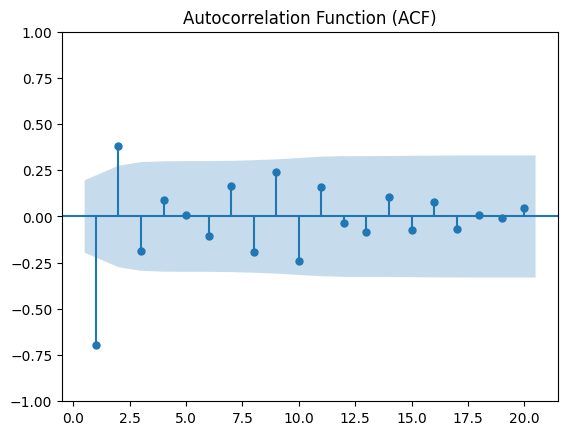

<Figure size 1000x400 with 0 Axes>

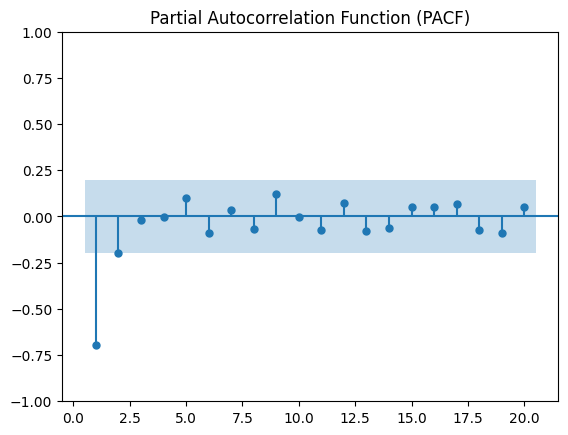

In [29]:
# Plot ACF
plt.figure(figsize=(10, 4))
plot_acf(df['total_amount_diff3'], lags=20, zero=False)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 4))
plot_pacf(df['total_amount_diff3'], lags=20, zero=False)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [30]:
# Extract the target variable
y = df['total_amount']

# Fit auto ARIMA model
model = auto_arima(y, seasonal=False, suppress_warnings=True)

# Display the model summary
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1546.310
Date:                Mon, 11 Mar 2024   AIC                           3102.620
Time:                        10:53:40   BIC                           3115.596
Sample:                             0   HQIC                          3107.870
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0079      0.210      4.810      0.000       0.597       1.419
ar.L2         -0.3772      0.213     -1.769      0.077      -0.795       0.041
ma.L1         -1.3697      0.074    -18.410      0.0

In [35]:
y3 = df['total_amount_diff3']

In [41]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


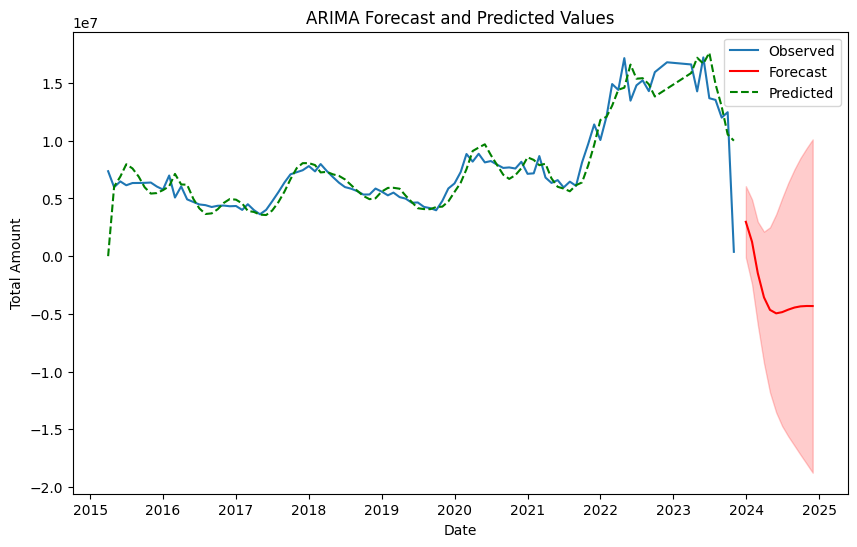

mape 0.36657771387378174
R2 Score: 0.7982


In [43]:
# Fit the ARIMA model
model.fit(y)

# Forecast future values
future_steps = 12  # Forecast for the next 2 months
forecast, conf_int = model.predict(n_periods=future_steps, return_conf_int=True)

# Generate future dates for the next 2 months
future_dates = pd.date_range(start=y.index[-1], periods=future_steps + 1, freq='M')[1:]

# Generate predicted values for the observed period
predicted_values = model.predict_in_sample()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Observed')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.plot(y.index, predicted_values, label='Predicted', color='green', linestyle='--')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2)
plt.title('ARIMA Forecast and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.show()
# Calculate MAPE using scikit-learn
y_true=y
mape = mean_absolute_percentage_error(y_true,predicted_values )
print('mape',mape)

# Calculate R2 score
r2 = r2_score(y_true, predicted_values)
print(f'R2 Score: {r2:.4f}')

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978:

                               SARIMAX Results                                
Dep. Variable:     total_amount_diff3   No. Observations:                  100
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1571.010
Date:                Mon, 11 Mar 2024   AIC                           3152.019
Time:                        11:53:44   BIC                           3164.995
Sample:                             0   HQIC                          3157.269
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0052      0.302     -3.325      0.001      -1.598      -0.413
ar.L2         -0.3422      0.303     -1.128      0.259      -0.936       0.252
ma.L1         -1.8885      0.112    -16.866      0.0

c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


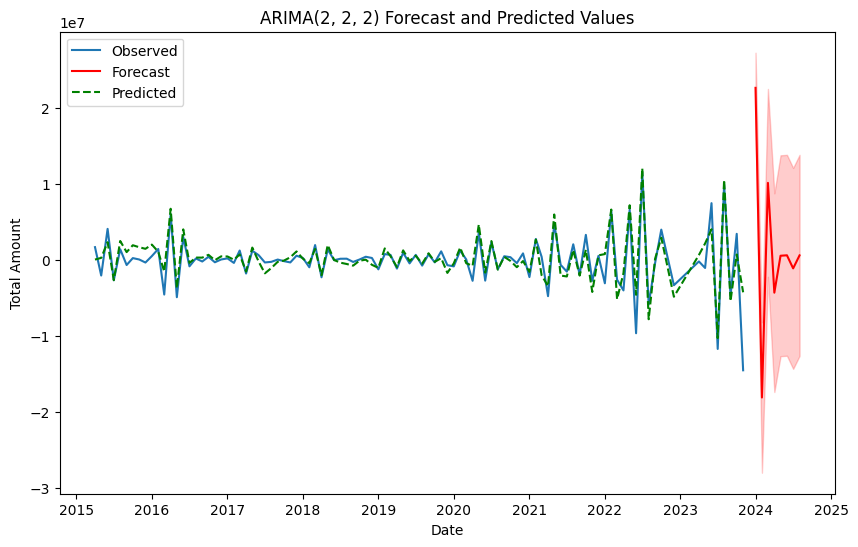

mape 5.047902980987361
R2 Score: 0.7750


In [40]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Fit ARIMA(1, 2, 1) model
model1 = ARIMA(y3, order=(2, 1, 2))
results = model1.fit()

# Display the model summary
print(results.summary())

# Forecast future values
future_steps = 8  # Forecast for the next 8 months
forecast = results.get_forecast(steps=future_steps)

# Generate future dates for the next 8 months
future_dates = pd.date_range(start=y3.index[-1], periods=future_steps + 1, freq='M')[1:]

# Generate predicted values for the observed period
predicted_values = results.fittedvalues

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(y3.index, y3, label='Observed')
plt.plot(future_dates, forecast.predicted_mean, label='Forecast', color='red')
plt.plot(y3.index, predicted_values, label='Predicted', color='green', linestyle='--')
plt.fill_between(future_dates, forecast.conf_int().values[:, 0], forecast.conf_int().values[:, 1], color='red', alpha=0.2)
plt.title('ARIMA(2, 2, 2) Forecast and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

# Evaluate the model
# Extract the target variable for evaluation
y_true = y3

# Calculate MAPE using scikit-learn
mape = mean_absolute_percentage_error(y_true,predicted_values )
print('mape',mape)

# Calculate R2 score
r2 = r2_score(y_true, predicted_values)
print(f'R2 Score: {r2:.4f}')


In [44]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Forecast future values
future_steps = 8  # Forecast for the next 8 months
forecast = results.get_forecast(steps=future_steps)

# Generate future dates for the next 8 months
future_dates = pd.date_range(start=y1.index[-1], periods=future_steps + 1, freq='M')[1:]

# Generate predicted values for the observed period
predicted_values = results.fittedvalues

# Extract the target variable for evaluation
y_true = y1

# Calculate MAPE using scikit-learn
mape = mean_absolute_percentage_error(y_true, predicted_values)
print(f'MAPE: {mape:.2f}%')

# Calculate R2 score
r2 = r2_score(y_true, predicted_values)
print(f'R2 Score: {r2:.4f}')


c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


NameError: name 'y1' is not defined

c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rushabh.parikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978:

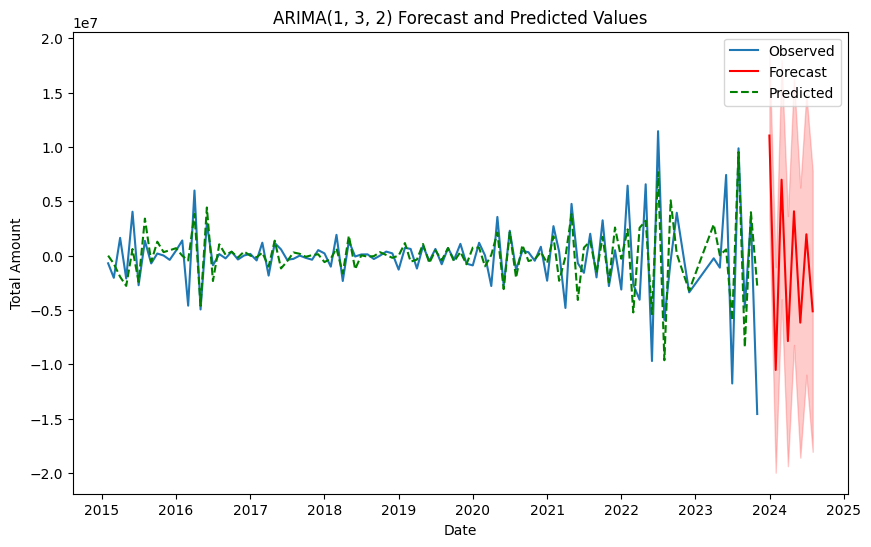

MAPE: 7.0823173216507485
R2 Score: 0.3128


In [193]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Fit ARIMA(1, 2, 1) model
model1 = ARIMA(y3, order=(1, 2, 2))
results = model1.fit()

# Forecast future values
future_steps = 8  # Forecast for the next 8 months
forecast = results.get_forecast(steps=future_steps)

# Generate future dates for the next 8 months
future_dates = pd.date_range(start=y3.index[-1], periods=future_steps + 1, freq='M')[1:]

# Generate predicted values for the observed period
predicted_values = results.fittedvalues

# Plot the forecast on the original time series
plt.figure(figsize=(10, 6))
plt.plot(y3.index, y3, label='Observed')
plt.plot(future_dates, forecast.predicted_mean, label='Forecast', color='red')
plt.plot(y3.index, predicted_values, label='Predicted', color='green', linestyle='--')
plt.fill_between(future_dates, forecast.conf_int().values[:, 0], forecast.conf_int().values[:, 1], color='red', alpha=0.2)
plt.title('ARIMA(1, 3, 2) Forecast and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.legend()
plt.show()

# Evaluate the model on the original time series
# Extract the target variable for evaluation
y_true = y3[-future_steps:]

# Calculate MAPE using scikit-learn
mape = mean_absolute_percentage_error(y_true, forecast.predicted_mean)
print('MAPE:', mape)

# Calculate R2 score
r2 = r2_score(y_true, forecast.predicted_mean)
print(f'R2 Score: {r2:.4f}')


Analysis based on Shift 12 dataset


In [75]:
# Take the first difference
df['total_amount_diff12'] = df['total_amount']-df['total_amount'].shift(12)

# Drop any missing values introduced by differencing
df.dropna(inplace=True)

# Perform ADF test on the differenced series
result_diff = adfuller(df['total_amount_diff12'])

# Extract and print ADF test results for the differenced series
adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]
critical_values_diff = result_diff[4]

print(f'ADF Statistic (after differencing): {adf_statistic_diff}')
print(f'p-value (after differencing): {p_value_diff}')
print('Critical Values (after differencing):', {key: value for key, value in critical_values_diff.items()})

# Interpret the results after differencing
if p_value_diff <= 0.05:
    print('Reject the null hypothesis. The differenced time series is likely stationary.')
else:
    print('Fail to reject the null hypothesis. The differenced time series may not be stationary.')

ADF Statistic (after differencing): -2.194249327080489
p-value (after differencing): 0.20833923619386052
Critical Values (after differencing): {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
Fail to reject the null hypothesis. The differenced time series may not be stationary.


In [82]:
df

Preprocessing pipeline


In [175]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta

In [165]:
def preprocessor(df):
    try:
        df['total_amount'] = df['total_amount'].astype(float)
        df['payment_month'] = pd.to_datetime(df['payment_month'])
        #print(df.head())
        q1 = np.quantile(df['total_amount'], 0.25)
        q3 = np.quantile(df['total_amount'], 0.75)
        IQRamount = q3 - q1
        print(IQRamount)
        
        # Keep track of indices to drop
        indices_to_drop = []
        
        for i in range(len(df['total_amount'])):
            if df['total_amount'][i] < q1 - 3 * IQRamount or df['total_amount'][i] > q3 + 3 * IQRamount:
                indices_to_drop.append(i)
            #print("hii")
        #print(indices_to_drop)
        # Remove outliers from the DataFrame
        df.drop(df.index[indices_to_drop], inplace=True)
        #print("hii")
        # Extract the target variable
        y = df['total_amount']

        # Fit auto ARIMA model
        model = auto_arima(y, seasonal=False, suppress_warnings=True)
        
        return df
    
    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        return pd.DataFrame()

In [166]:
# Save the preprocessing function to a pickle file
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [162]:
df1=preprocessor(df)
print(df1)

3127427.25
    payment_month  total_amount
0      2014-11-01        492.02
1      2014-12-01    1104501.72
2      2015-01-01    3264438.51
3      2015-02-01    5774512.00
4      2015-03-01    6595677.07
..            ...           ...
104    2023-07-01   13691524.10
105    2023-08-01   13546074.69
106    2023-09-01   12012384.04
107    2023-10-01   12478845.53
108    2023-11-01     375307.82

[105 rows x 2 columns]


In [178]:
def modelarima(df):
    try:
        df['total_amount'] = df['total_amount'].astype(float)
        df['payment_month'] = pd.to_datetime(df['payment_month'])
        
        q1 = np.quantile(df['total_amount'], 0.25)
        q3 = np.quantile(df['total_amount'], 0.75)
        IQRamount = q3 - q1
        print(IQRamount)
        
        # Keep track of indices to drop
        indices_to_drop = []
        
        for i in range(len(df['total_amount'])):
            if df['total_amount'][i] < q1 - 3 * IQRamount or df['total_amount'][i] > q3 + 3 * IQRamount:
                indices_to_drop.append(i)
        
        # Remove outliers from the DataFrame
        df.drop(df.index[indices_to_drop], inplace=True)
        
        # Extract the target variable
        y = df['total_amount']

        # Fit auto ARIMA model
        model = auto_arima(y, seasonal=False, suppress_warnings=True)
        
        last_date=df['payment_month'].max()
        # Forecast future values
        future_steps = 12  # Forecast for the next 2 months
        forecast, conf_int = model.predict(n_periods=future_steps, return_conf_int=True)

        # Generate future dates for the next 2 months
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, 121)]

        # Generate predicted values for the observed period
        predicted_values = model.predict_in_sample()
        
        
       
        
        return df
    
    except Exception as e:
        print(f"An error occurred during preprocessing: {e}")
        return pd.DataFrame()

In [179]:
df1=modelarima(df)

3045341.92
An error occurred during preprocessing: 96
